In [1]:
import pandas as pd
import numpy as np

import datetime as dt

from statsmodels.tsa.stattools import acf, pacf

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib as mpl

# Data

In [35]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])
df = df.rename(columns={'date':'ds','value':'y'})
df

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869
...,...,...
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510


In [3]:
def time_series_plot(
    df,
    figsize = (7,5),
    time_series_name = None,  
    solo_plot = True, 
    ax = None,
):
    
    # Grab the current axis if none provided. 
    if solo_plot is True and ax is None:
        ax = None
    elif solo_plot is False and ax is None:
        ax=plt.gca()

    # Grab the name of the time series
    if time_series_name == None:
        time_series_name = df['y'].name

    # Build a solo plot
    if solo_plot:
        fig, ax = plt.subplots(figsize=figsize)

    # Determine the horizontal label for the time series and ticker 
    if np.issubdtype(df['ds'], np.datetime64):
        time_series_id_label = 'Date'

    elif np.issubdtype(df['ds'], np.number):
        time_series_id_label = 'Series Number'
    else: 
        time_series_id_label = 'Row Number'

    marker = "o" if len(df['ds']) < 50 else "."

    ax.scatter(
        df['ds'], 
        df['y'],
        marker=marker, 
        s = 70, 
        color="grey", ec="k", alpha=1, 
        label = 'Eigenvalue'
    )

    ax.plot(
        df['ds'],
        df['y'],
        color='steelblue', alpha=1,
        linewidth=1
    )

    ax.set_xlabel(f'\n(x)  {time_series_id_label}', fontsize=12)
    ax.set_ylabel(f'(y)  {time_series_name}\n', fontsize=12)
    ax.set_title(f'\nTime Series {time_series_name}\n', fontsize=12)

    if solo_plot is True:
        plt.show()
        plt.close()
        return 

    return ax


In [4]:
def weekly_seasonal_boxplots(df, figsize=(7,5), solo_plot=True, ax=None):
    
    """
    Creates side-by-side boxplots showing weekly seasonality.
    """
    
    # Get Vals
    day_name_vals = df['ds'].dt.day_name()
    values = df['y']
    
    # Create DataFrame to Plot
    data = pd.DataFrame({'day_name':day_name_vals, 'values':values})
    data = data.pivot(columns='day_name', values = 'values')
    rename_dict = {
        'Monday':'Mon','Tuesday':'Tue','Wednesday':'Wed','Thursday':'Thu','Friday':'Fri','Saturday':'Sat', 'Sunday':'Sun'
    }
    col_names = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    data = data.rename(columns=rename_dict)[col_names]
    
    # Build a solo plot
    if solo_plot:
        fig, ax = plt.subplots(figsize=figsize)
        
    ax = data.boxplot(
        figsize=(7,5),
        grid=False,
        return_type='axes'
    )
    ax.set_title('\nWeekly\n', fontsize=15)
    
    return ax

In [5]:
def monthly_seasonal_boxplots(df, figsize=(7,5), solo_plot=True, ax=None):
    
    """
    Creates side-by-side boxplots showing monthly seasonality.
    """

    # Get Vals
    month_name_vals = df['ds'].dt.month_name()
    values = df['y']
        
    # Create DataFrame to Plot
    data = pd.DataFrame({'month_name':month_name_vals, 'values':values})
    data = data.pivot(columns='month_name', values = 'values')

    rename_dict = {
        'January':'Jan','February':'Feb','March':'Mar','April':'Apr','May':'May','June':'Jun',
        'July':'Jul', 'August':'Aug','September':'Sep','October':'Oct','November':'Nov','December':'Dec'
    }
    col_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    data = data.rename(columns=rename_dict)[col_names]

    # Build a solo plot
    if solo_plot:
        fig, ax = plt.subplots(figsize=figsize)

    ax = data.boxplot(
        figsize=(7,5),
        grid=False,
        return_type='axes'
    )
    ax.set_title('\nMonthly\n', fontsize=15)
    
    return ax

In [6]:
def yearly_seasonal_boxplots(df, figsize=(18,5), solo_plot=True, ax=None):
    
    """
    Creates side-by-side boxplots showing yearly seasonality.
    """
    
     # Get Vals   
    year_vals = df['ds'].dt.year
    values = df['y']

    # Create DataFrame to Plot
    data = pd.DataFrame({'year':year_vals, 'values':values})
    data = data.pivot(columns='year', values = 'values')
    data = data[data.columns.sort_values()] # make sure the dates are in order
    

    # Build a solo plot
    if solo_plot:
        fig, ax = plt.subplots(figsize=figsize)
        
    ax = data.boxplot(
        grid=False,
        return_type='axes'
    )
    ax.set_title('\nYearly\n', fontsize=15)
    
    return ax

In [7]:
def seasonal_boxplots(df, figsize=(12,9)):
    
    fig = plt.figure(constrained_layout=True, figsize=figsize) 
    specs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig) 

    ax1 = fig.add_subplot(specs[0, 0])
    ax1 = weekly_seasonal_boxplots(df, figsize=(figsize[0]/2,5), solo_plot=False, ax=ax1)
    
    ax2 = fig.add_subplot(specs[0, 1]) 
    ax2 = monthly_seasonal_boxplots(df, figsize=(figsize[0]/2,5), solo_plot=False, ax=ax2)

    ax3 = fig.add_subplot(specs[1, :]) 
    ax3 = yearly_seasonal_boxplots(df, figsize=(figsize[0],5), solo_plot=False, ax=ax3)
    
    plt.show()

In [8]:
def time_series_diagnostic_values(df):

    num_lags= 25 if len(df) >=25 else len(df)

    acf_values, acf_interval, ljung_box_vals, p_vals = acf(
        x=df['y'],
        nlags=num_lags,
        qstat=True,
        alpha=0.05, 
        fft=False
    )

    pacf_values, pacf_interval = pacf(
        x=df['y'],
        nlags=num_lags,
        method='ywadjusted',
        alpha=0.05
    )

    autocorrelations = pd.DataFrame(
        {'Lag':np.arange(num_lags+1),
         'AutoCorr':[val for val in acf_values],
         'ACF Inervals':[val for val in acf_interval],
         'Ljung_Box Q':[val for val in np.insert(ljung_box_vals, 0, None)],
         'p-Value':[val for val in np.insert(p_vals, 0, None)],
         'Partial':[val for val in pacf_values],
         'PACF Intervals':[val for val in pacf_interval]
        }
    )

    return autocorrelations

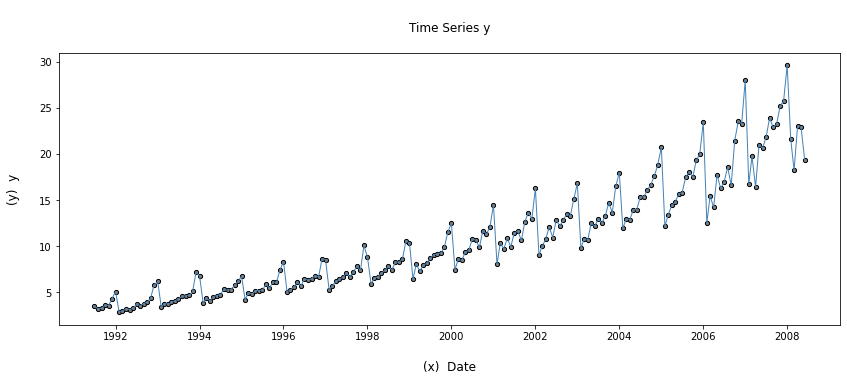

In [9]:
time_series_plot(df,figsize = (14,5))

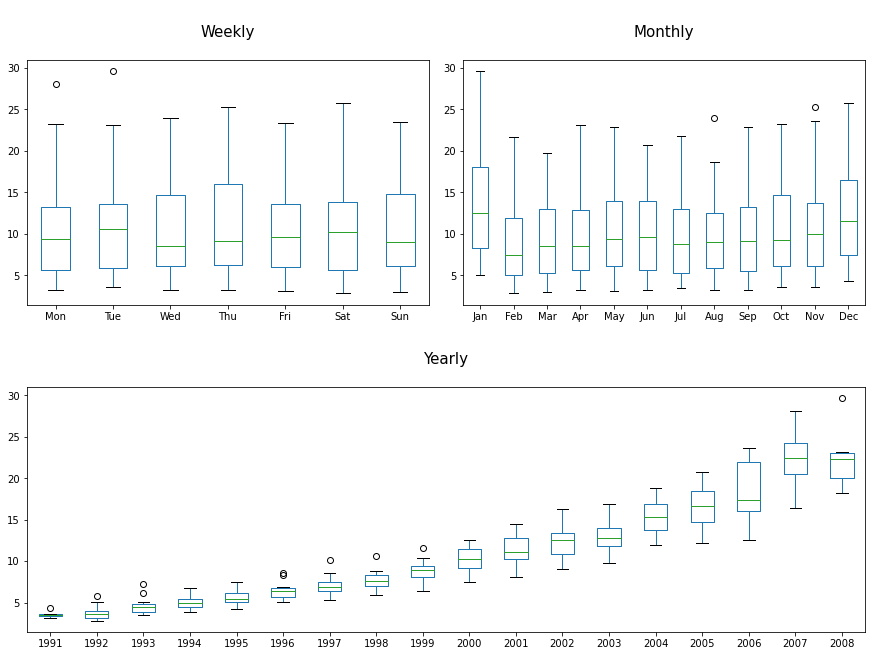

In [10]:
seasonal_boxplots(df, figsize=(12,9))

In [11]:
diagnostic_vals = time_series_diagnostic_values(df)
diagnostic_vals

,Lag,AutoCorr,ACF Inervals,Ljung_Box Q,p-Value,Partial,PACF Intervals
0,0,1.000000,"[1.0, 1.0]",NaN,NaN,1.000000,"[1.0, 1.0]"
1,1,0.920568,"[0.783343220940938, 1.0577930742373]",175.433787,4.813705e-40,0.930521,"[0.7932958463779531, 1.067745699674315]"
2,2,0.887825,"[0.662555043754761, 1.1130953392178884]",339.417587,1.978826e-74,0.345884,"[0.20865950020033247, 0.4831093534966944]"
3,3,0.853859,"[0.5702522262049217, 1.1374650205070798]",491.848576,2.787243e-106,0.135883,"[-0.001342048185296263, 0.2731078051110657]"
4,4,0.840528,"[0.5120614722257795, 1.1689953449082848]",640.295836,2.939213e-137,0.172727,"[0.035502064776182174, 0.30995191807254413]"
5,5,0.825238,"[0.45849823527994493, 1.1919771459017707]",784.110251,3.167141e-167,0.155316,"[0.0180914508820669, 0.29254130417842883]"
6,6,0.796297,"[0.3961142864064361, 1.1964788643852304]",918.690676,3.419747e-195,0.091672,"[-0.045553009968255675, 0.22889684332810628]"
7,7,0.779502,"[0.35051847942547487, 1.2084846567868905]",1048.308626,4.383473e-222,0.139140,"[0.0019155142926062796, 0.27636536758896824]"
8,8,0.759533,"[0.3046584739909332, 1.2144065446619228]",1171.998472,1.075302e-247,0.126934,"[-0.010291384773786855, 0.2641584685225751]"
9,9,0.743376,"[0.26521603869487786, 1.2215357273558944]",1291.089683,2.599520e-272,0.110982,"[-0.026242538434514795, 0.24820731486184716]"


In [268]:
acf_vals, acf_intervals, ljung_box_vals, p_vals = acf(df['y'], nlags=n_lags, qstat=True, alpha=0.05, fft=False)

In [271]:
len(acf_intervals)

26

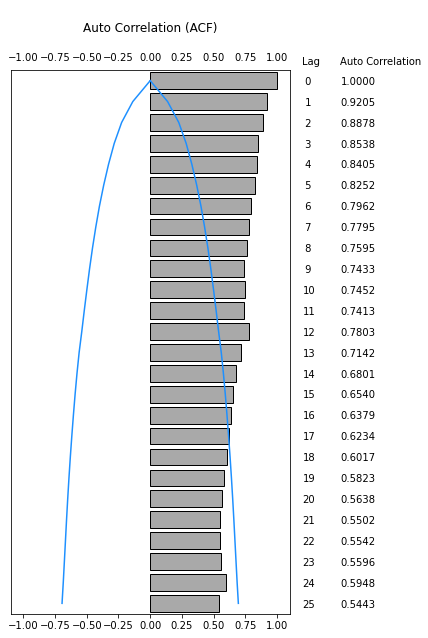

In [214]:
# Defaults
figsize = (5,10)
solo_plot = True

# Obtain vals
n_lags = 25 if len(df.y) >= 25 else len(df.y) 
acf_vals, acf_intervals, ljung_box_vals, p_vals = acf(df['y'], nlags=n_lags, qstat=True, alpha=0.05, fft=False)

acf_lower = acf_intervals[:,0]-acf_vals
acf_upper = acf_intervals[:,1]-acf_vals
lags = np.arange(0,n_lags+1, 1)

# Build a solo plot
if solo_plot:
    fig, ax = plt.subplots(figsize=figsize)

# Build axis
ax.barh(lags, acf_vals, align='center', color='darkgrey',edgecolor='black')

ax.set_xlim(-1.1,1.1)
ax.set_ylim(-0.5, n_lags+0.5)
ax.plot(acf_lower, lags, color='dodgerblue')
ax.plot(acf_upper, lags, color='dodgerblue')
ax.set_yticks(lags)
ax.set_title('\nAuto Correlation (ACF)\n')
ax.tick_params(labelbottom=False,labeltop=True)

for lag_val, acf_val in zip(lags, acf_vals):
    acf_text = str(acf_val.item())[0:6]
    lag_text = str(lag_val.item())[0:2]
    lag_text = ' {}'.format(lag_text) if len(lag_text) == 1 else lag_text
    acf_text = '1.0000' if acf_text == '1.0' else acf_text
    ax.text(1.2, lag_val+0.2, lag_text)
    ax.text(1.5, lag_val+0.2, acf_text)

ax.text(1.2, -0.75, 'Lag')
ax.text(1.5, -0.75, "Auto Correlation")

ax.set_yticks([])
ax.tick_params(labelbottom=True,labeltop=True)
plt.gca().invert_yaxis()

In [ ]:
for lag_val, acf_val in zip(lags, acf_vals):
    acf_text = str(acf_val.item())[0:6]
    lag_text = str(lag_val.item())[0:2]
    lag_text = ' {}'.format(lag_text) if len(lag_text) == 1 else lag_text
    acf_text = '1.0000' if acf_text == '1.0' else acf_text
    ax.text(1.2, lag_val+0.2, lag_text)
    ax.text(1.5, lag_val+0.2, acf_text)

ax.text(1.2, -0.75, 'Lag')
ax.text(1.5, -0.75, "Auto Correlation")

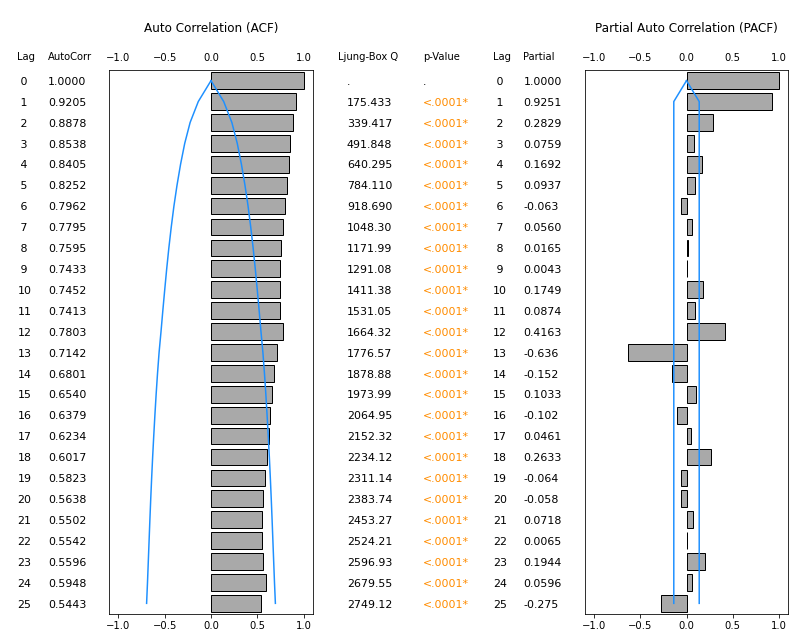

In [334]:
# Defaults
figsize = (14,10)
solo_plot = True

# Obtain vals
n_lags = 25 if len(df.y) >= 25 else len(df.y) 
lags = np.arange(0,n_lags+1, 1)

#ACF Vals
acf_vals, acf_intervals, ljung_box_vals, p_vals = acf(df['y'], nlags=n_lags, qstat=True, alpha=0.05, fft=False)
acf_lower = acf_intervals[:,0]-acf_vals
acf_upper = acf_intervals[:,1]-acf_vals

#PACF Vals
pacf_vals, pacf_intervals = pacf(df.y,nlags=n_lags,alpha=0.05)
pacf_lower = pacf_intervals[:,0]-pacf_vals
pacf_upper = pacf_intervals[:,1]-pacf_vals

#Ljung-Box Q and P-vals
ljung_box_vals = np.insert(ljung_box_vals, 0, np.nan, axis=0)
p_vals = np.insert(p_vals, 0, np.nan, axis=0)

# Create side by side figures
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, figsize = figsize, 
                               gridspec_kw={'width_ratios': [1.5, 3, 2.5, 1.5, 3]})
fig.subplots_adjust(wspace=0) # remove vertical space between axes

# Build Text For ACF Plot
for lag_val, acf_val in zip(lags, acf_vals):
    acf_text = str(acf_val.item())[0:6]
    lag_text = str(lag_val.item())[0:2]
    lag_text = ' {}'.format(lag_text) if len(lag_text) == 1 else lag_text
    acf_text = '1.0000' if acf_text == '1.0' else acf_text
    
    ax1.text(0.1, lag_val+0.2, lag_text, fontsize=11)
    ax1.text(0.4, lag_val+0.2, acf_text, fontsize=11)

ax1.text(0.1, -1.0, 'Lag')
ax1.text(0.4, -1.0, "AutoCorr")
ax1.tick_params(labelbottom=False,labeltop=False)
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_axis_off()

# Build ACF Plot
ax2.barh(lags, acf_vals, align='center', color='darkgrey',edgecolor='black')
ax2.plot(acf_lower, lags, color='dodgerblue')
ax2.plot(acf_upper, lags, color='dodgerblue')
ax2.set_title('\nAuto Correlation (ACF)\n')

ax2.set_xlim(-1.1,1.1)
ax2.set_ylim(-0.5, n_lags+0.5)

ax2.tick_params(labelbottom=True,labeltop=True)
ax2.set_yticks([])
ax2.invert_yaxis()

# Build Text For Ljung-Box Q
for lag_val, q_val, p_val in zip(lags, ljung_box_vals, p_vals):
    
    if p_val < 0.001:
        p_text = '<.0001*'
        p_color = 'darkorange'
    elif p_val < 0.05:
        p_text = '<.0500*'
        p_color = 'maroon'
    else:
        p_text = str(p_val.item())[0:6]
        p_color = 'black'
        
    q_text = str(q_val.item())[0:7]
    q_text = '.' if q_text == 'nan' else q_text
    p_text = '.' if p_text == 'nan' else p_text

    ax3.text(0.20, lag_val+0.2, q_text, fontsize=11)
    ax3.text(0.65, lag_val+0.2, p_text, fontsize=11, color=p_color)

ax3.text(0.15, -1.0, 'Ljung-Box Q')
ax3.text(0.65, -1.0, "p-Value")
ax3.tick_params(labelbottom=False,labeltop=False)
ax3.set_yticks([])
ax3.set_xticks([])
ax3.set_axis_off()

# Build Text For PACF Plot
for lag_val, pacf_val in zip(lags, pacf_vals):
    pacf_text = str(pacf_val.item())[0:6]
    lag_text = str(lag_val.item())[0:2]
    lag_text = ' {}'.format(lag_text) if len(lag_text) == 1 else lag_text
    pacf_text = '1.0000' if pacf_text == '1.0' else pacf_text
    
    ax4.text(0.1, lag_val+0.2, lag_text, fontsize=11)
    ax4.text(0.4, lag_val+0.2, pacf_text, fontsize=11)

ax4.text(0.1, -1.0, 'Lag')
ax4.text(0.4, -1.0, "Partial")
ax4.tick_params(labelbottom=False,labeltop=False)
ax4.set_yticks([])
ax4.set_xticks([])
ax4.set_axis_off()

# Build PACF Plot
ax5.barh(lags, pacf_vals, align='center', color='darkgrey',edgecolor='black')
ax5.plot(pacf_lower, lags, color='dodgerblue')
ax5.plot(pacf_upper, lags, color='dodgerblue')
ax5.set_title('\nPartial Auto Correlation (PACF)\n')

ax5.set_xlim(-1.1,1.1)
ax5.set_ylim(-0.5, n_lags+0.5)

ax5.tick_params(labelbottom=True,labeltop=True)
ax5.set_yticks([])
ax5.invert_yaxis()

plt.show()
plt.close()




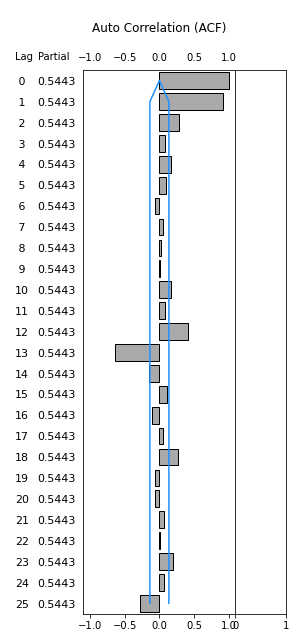

In [318]:
# Defaults
figsize = (5,10)
solo_plot = True

# Obtain PACF vals
n_lags = 25 if len(df.y) >= 25 else len(df.y) 
pacf_vals, pacf_intervals = pacf(df.y,nlags=n_lags,alpha=0.05)
pacf_lower = pacf_intervals[:,0]-pacf_vals
pacf_upper = pacf_intervals[:,1]-pacf_vals
lags = np.arange(0,n_lags+1, 1)


# Create side by side figures
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize = figsize, 
                               gridspec_kw={'width_ratios': [1.5, 3, 1]})
fig.subplots_adjust(wspace=0) # remove vertical space between axes

# Build Text For PACF Plot
for lag_val, pacf_val in zip(lags, pacf_vals):
    pacf_text = str(pacf_val.item())[0:6]
    lag_text = str(lag_val.item())[0:2]
    lag_text = ' {}'.format(lag_text) if len(lag_text) == 1 else lag_text
    pacf_text = '1.0000' if pacf_text == '1.0' else pacf_text
    
    ax1.text(0.1, lag_val+0.2, lag_text, fontsize=11)
    ax1.text(0.4, lag_val+0.2, acf_text, fontsize=11)

ax1.text(0.1, -1.0, 'Lag')
ax1.text(0.4, -1.0, "Partial")
ax1.tick_params(labelbottom=False,labeltop=False)
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_axis_off()

# Build ACF Plot
ax2.barh(lags, pacf_vals, align='center', color='darkgrey',edgecolor='black')
ax2.plot(pacf_lower, lags, color='dodgerblue')
ax2.plot(pacf_upper, lags, color='dodgerblue')
ax2.set_title('\nAuto Correlation (ACF)\n')

ax2.set_xlim(-1.1,1.1)
ax2.set_ylim(-0.5, n_lags+0.5)

ax2.tick_params(labelbottom=True,labeltop=True)
ax2.set_yticks([])
ax2.invert_yaxis()

plt.show()
plt.close()


In [275]:
# Obtain vals
n_lags = 25 if len(df.y) >= 25 else len(df.y) 
lags = np.arange(0,n_lags+1, 1)

#ACF Vals
acf_vals, acf_intervals, ljung_box_vals, p_vals = acf(df['y'], nlags=n_lags, qstat=True, alpha=0.05, fft=False)
acf_lower = acf_intervals[:,0]-acf_vals
acf_upper = acf_intervals[:,1]-acf_vals

#PACF Vals
pacf_vals, pacf_intervals = pacf(df.y,nlags=n_lags,alpha=0.05)
pacf_lower = pacf_intervals[:,0]-acf_vals
pacf_upper = pacf_intervals[:,1]-acf_vals

#Ljung-Box Q and P-vals
ljung_box_vals = np.insert(ljung_box_vals, 0, np.nan, axis=0)
p_vals = np.insert(p_vals, 0, np.nan, axis=0)


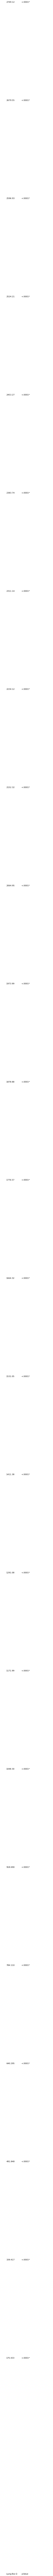

In [296]:
fig, ax3 = plt.subplots(figsize = figsize)
                                    
# Build Text For Ljung-Box Q
for lag_val, q_val, p_val in zip(lags, ljung_box_vals, p_vals):
    
    if p_val < 0.001:
        p_text = '<.0001*'
    elif p_val < 0.05:
        p_text = '<.0500*'
    else:
        p_text = str(p_val.item())[0:6]

    q_text = str(q_val.item())[0:7]
    q_text = '' if q_text == 'nan' else q_text
    p_text = '' if p_text == 'nan' else p_text

    ax3.text(0.1, lag_val+0.2, q_text, fontsize=11)
    ax3.text(0.4, lag_val+0.2, p_text, fontsize=11)

ax3.text(0.1, -1.0, 'Ljung-Box Q')
ax3.text(0.4, -1.0, "p-Value")
ax3.tick_params(labelbottom=False,labeltop=False)
ax3.set_yticks([])
ax3.set_xticks([])
ax3.set_axis_off()

In [282]:
p_vals


array([            nan, 4.81370497e-040, 1.97882572e-074, 2.78724330e-106,
       2.93921282e-137, 3.16714081e-167, 3.41974743e-195, 4.38347343e-222,
       1.07530217e-247, 2.59951951e-272, 3.45031967e-297, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000])

In [91]:
acf_vals

array([1.        , 0.92056815, 0.88782519, 0.85385862, 0.84052841,
       0.82523769, 0.79629658, 0.77950157, 0.75953251, 0.74337588,
       0.74521347, 0.74134847, 0.78031252, 0.71424686, 0.68014097,
       0.65401657, 0.63791893, 0.62349882, 0.60171747, 0.58230335,
       0.5638103 , 0.5502367 , 0.55428812, 0.55963579, 0.5948865 ,
       0.5443742 ])

ValueError: x and y must have same first dimension, but have shapes (15,) and (26,)

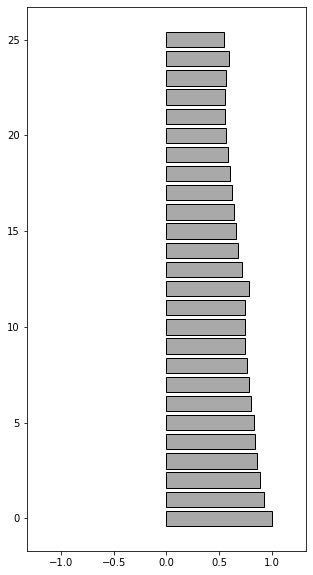

In [24]:
df = diagnostic_vals.sort_values(by='Lag', ascending=False)
figsize = (5,10)
solo_plot = True

# Build a solo plot
if solo_plot:
    fig, ax = plt.subplots(figsize=figsize)

# Extract ACF upper and lower intervals
acf_lower, acf_upper = map(list, zip(*(df['ACF Inervals'])))
acf_vals = df['AutoCorr'].tolist()
ax.barh(df['Lag'], df['AutoCorr'], align='center', color='darkgrey',edgecolor='black')
ax.set_xlim(-max(abs(max(acf_lower)),abs(max(acf_upper))), max(abs(max(acf_lower)),abs(max(acf_upper))))

acf_lower =pacf_interval[1:,0] - pacf_value[1:]
acf_upper =pacf_interval[1:, 1]- pacf_value[1:]

ax.plot(acf_lower, df['Lag'])
ax.plot(acf_upper, df['Lag'])
ax.set_ylim(-0.5,25.5)

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df.df['y'].tolist(), lags=50, ax=axes[0])
plot_pacf(df.df['y'].tolist(), lags=50, ax=axes[1])

In [ ]:
max(abs(max(acf_lower)),abs(max(acf_upper)))

In [ ]:
stuff_check = df['ACF Inervals']
test_a,test_b = map(list, zip(*stuff_check))
test_a

In [ ]:
[item[0] for item in df['ACF Inervals'].tolist()]

In [ ]:
a = ("John", "Charles", "Mike")
b = ("Jenny", "Christy", "Monica", "Vicky")

x = zip(a, b)
*x

In [ ]:
a = [1,2,3]
b = [4,5,6]
zipped_list = zip(a,b)

In [ ]:
#x = lambda x: zip(*zipped_list)
test_a,test_b = map(list, zip(*zipped_list))

In [ ]:
test_a